## view precipitation

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os
from shapely.geometry import Polygon
from shapely.geometry import Point
import geopandas as gpd
from tqdm import tqdm
from xarray import open_dataset



In [19]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def get_mask_chile_central(lat_values, lon_values):
    # Definir el polígono de Chile central (aproximadamente)
    central_chile_coords = [
        (-75, -40),  # Esquina inferior izquierda
        (-70, -40),  # Esquina inferior derecha
        (-70, -32),  # Esquina superior derecha
        (-75, -32)   # Esquina superior izquierda
    ]

    central_chile_polygon = Polygon(central_chile_coords)
    shapefile_path = "W:/Proyectos/paleoclimate_global_simulations_chile_central/data/country_shp/ne_110m_admin_0_countries.shp"
    world = gpd.read_file(shapefile_path)

    central_chile_shape = gpd.GeoDataFrame(geometry=[central_chile_polygon], crs="EPSG:4326")
    
    chile = world[world.NAME_EN == "Chile"]
    central_chile_mask = gpd.overlay(chile, central_chile_shape, how='intersection')
    mask = np.zeros((12, len(lat_values), len(lon_values)), dtype=bool)

    for i, lat in tqdm(enumerate(lat_values)):
        for j, lon in enumerate(lon_values):
            point = Point(lon, lat)
            if central_chile_mask.geometry.apply(lambda x: x.contains(point)).any():
                mask[:, i, j] = True
    return mask, central_chile_shape

In [14]:
path = 'data/processed/monthly_aggregated/'
experiments = ['historical', 'piControl', 'midHolocene', 'lgm']

def get_nc_files(path):
    return [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.nc')]


In [21]:


def select_region(array, lat_i, lat_f, lon_i, lon_f, lats, lons):
    
    lat_i_idx, lat_f_idx = np.abs(lats - lat_i).argmin(), np.abs(lats - lat_f).argmin()
    lon_i_idx, lon_f_idx = np.abs(lons - lon_i).argmin(), np.abs(lons - lon_f).argmin()
    return array[:, lat_i_idx:lat_f_idx, lon_i_idx:lon_f_idx]


def fix_lon(lons, lon_i, lon_f):

    if np.all(lons >= 0):
        lon_i_fix = lon_i + 360
        lon_f_fix  = lon_f + 360
    else:
        lon_i_fix = lon_i
        lon_f_fix = lon_f

    return lon_i_fix, lon_f_fix

def fix_lat(lats, lat_i, lat_f):

    if lats[0] <= 0:
        lat_i_fix = lat_f
        lat_f_fix = lat_i
    else:
        lat_i_fix = lat_i
        lat_f_fix = lat_f

    return lat_i_fix, lat_f_fix

def precip_chile_cetral(ds, lat_key='lat', lon_key='lon', code_name ='pr'):
    """
    Calculate the precipitation index from a dataset.
    """
    lats = ds[lat_key].values
    lons = ds[lon_key].values
    pr = ds[code_name].values

    if lons[0] >= 0:
        lons= np.where(lons > 180, lons - 360, lons)

    # if mask_chile_central file does not exist, create it
    try:
        mask = np.load(f'W:/Proyectos/paleoclimate_global_simulations_chile_central/data/mask_chile_central_{code_name}.npy')
    except:
        mask, central_chile_shape = get_mask_chile_central(lats, lons)
        np.save(f'W:/Proyectos/paleoclimate_global_simulations_chile_central/data/mask_chile_central_{code_name}.npy', mask)
        pr_masked = np.where(mask, pr, np.nan)
        # Visualización para verificar la máscara en un paso de tiempo específico
        fig = plt.figure(figsize=(10, 10))
        ax = plt.axes(projection=ccrs.PlateCarree())

        # Añadir las líneas costeras y bordes de los países
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        # Graficar la precipitación con la máscara aplicada
        lon_grid, lat_grid = np.meshgrid(lons, lats)
        precip_plot = ax.pcolormesh(lon_grid, lat_grid, pr_masked[0], transform=ccrs.PlateCarree(), cmap='Blues')

        # Añadir el polígono de Chile central
        central_chile_shape.boundary.plot(ax=ax, edgecolor='red')

        # Configurar límites de la gráfica
        ax.set_extent([-80, -60, -45, -25], crs=ccrs.PlateCarree())

        # Añadir colorbar
        plt.colorbar(precip_plot, ax=ax, orientation='horizontal', pad=0.05)

        # Mostrar la gráfica
        plt.show()

    pr_masked = np.where(mask, pr, np.nan)
    pr_chile = np.nanmean(pr_masked, axis=(1, 2))
    precip = pr_chile

    return precip


In [32]:
precips = []
for experiment in experiments:
    
    files = get_nc_files(f'W:/Proyectos/paleoclimate_global_simulations_chile_central/data/processed/monthly_aggregated/{experiment}/tp/')
    year_preps = []
    for file in tqdm(files):
        ds = open_dataset(file)
        precip = precip_chile_cetral(ds, code_name='tp')
        year_preps.append(precip)
    precips.append(year_preps)


 41%|████      | 412/1000 [01:16<01:22,  7.15it/s]w:\Proyectos\paleoclimate_global_simulations_chile_central\venv\Lib\site-packages\xarray\coding\times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
w:\Proyectos\paleoclimate_global_simulations_chile_central\venv\Lib\site-packages\xarray\core\indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
 41%|████▏     | 413/1000 [01:16<01:55,  5.09it/s]w:\Proyectos\paleoclimate_global_simulations_chile_central\venv\Lib\site-packages\xarray\coding\times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.date

AttributeError: 'list' object has no attribute 'shape'

In [133]:
precipitaciones = []
for prep in precips:
    prep = np.array(prep)
    #flat
    precipitaciones.append(np.sum(prep, axis=1))

print(precipitaciones[0])  

[1.25587    0.9552317  0.7417492  1.2837025  0.7901405  1.035946
 0.949348   0.9773626  1.0470246  1.0135275  1.3064039  1.1688387
 0.8205868  0.81605476 1.0979408  1.0067035  1.0263187  1.0691775
 0.8097909  0.91734153 1.3779622  1.2982074  1.1882355  1.1062115
 0.93099177 0.9370574  0.699975   0.82591623 1.0828668  0.96332026
 0.8648751  0.7913166  1.0376692  1.0740762  1.2527239  0.8518453
 0.9133222  0.78428113 0.88523144 1.1519074  1.5382628  1.3923234
 1.2996757  0.8954243  0.7404022  0.7856027  0.95948845 1.2010908
 0.87802994 0.8104013  0.9231267  0.8156642  1.0087711  0.7471434
 0.9429822  1.4934165  0.784236   1.058776   0.858426   0.8262269
 0.99321324 0.945588   0.9754106  1.6264815  1.0058495  1.1051055
 1.1349272  1.4609829  0.8492369  0.8491625  1.1526159  0.85299844
 0.88493145 1.0626674  0.99087626 1.1244338  0.890495   0.89379764
 0.8935265  1.1419382  0.98794323 0.98815084 1.2045482  0.89667416
 0.8841613  1.3327389  0.86235774 0.8339453  0.8208562  1.1124941
 0.9354

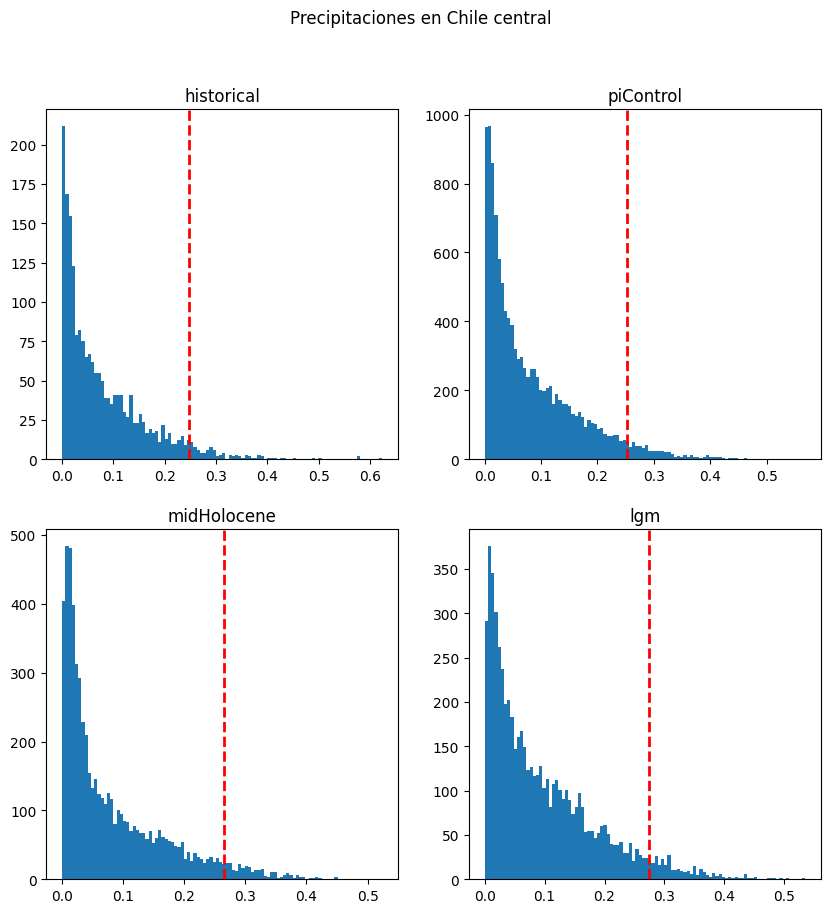

In [132]:
#plot histogram in 4 subplots

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Precipitaciones en Chile central')
for i, ax in enumerate(axs.flat):
    ax.hist(np.array(precips[i]).flatten(), bins=100)
    ax.set_title(experiments[i])
    #xline on percentile 95
    ax.axvline(np.percentile(np.array(precips[i]).flatten(), 95), color='r', linestyle='dashed', linewidth=2)

plt.show()

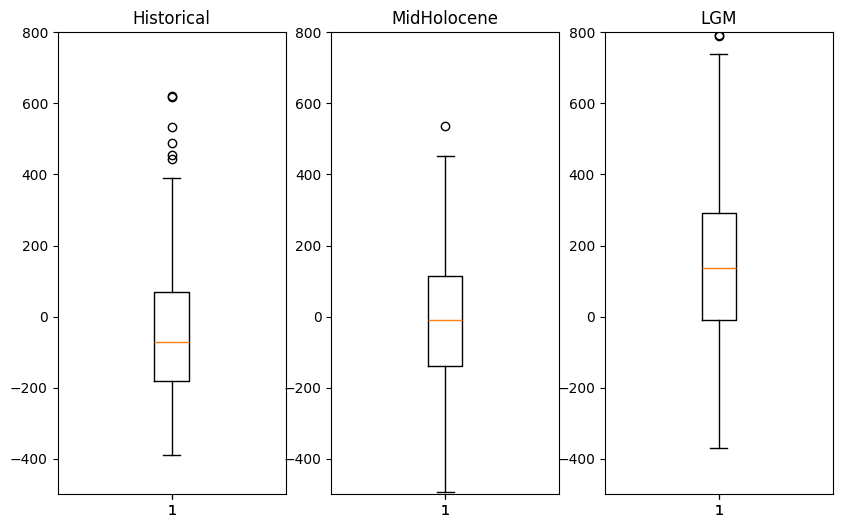

In [57]:


prep_hist = np.array(precipitaciones[0])*1000
prep_piControl = np.array(precipitaciones[1])*1000
prep_midHolocene = np.array(precipitaciones[2])*1000
prep_lgm = np.array(precipitaciones[3])*1000

fig, ax = plt.subplots(1, 3, figsize=(10, 6), sharex=True)

ax[0].boxplot(prep_hist - np.mean(prep_piControl), label=['Historical'])
ax[0].set_ylim(-500, 800)
ax[0].set_title('Historical')
ax[1].boxplot(prep_midHolocene - np.mean(prep_piControl), label=['MidHolocene'])
ax[1].set_ylim(-500, 800)

ax[1].set_title('MidHolocene')
ax[2].boxplot(prep_lgm - np.mean(prep_piControl), label=['LGM'])
ax[2].set_ylim(-500, 800)

ax[2].set_title('LGM')

plt.show()


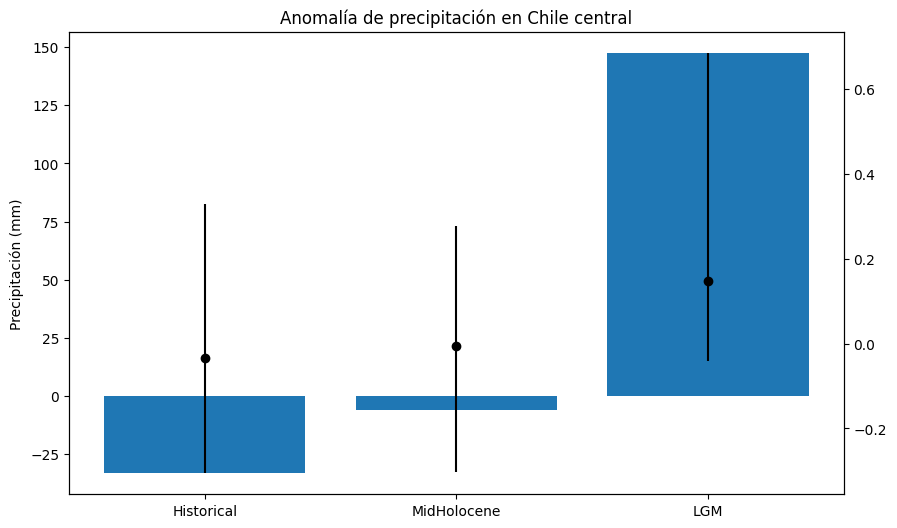

In [63]:
# plot barplot
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
ax.bar(['Historical', 'MidHolocene', 'LGM'], [np.mean(prep_hist)-np.mean(prep_piControl), np.mean(prep_midHolocene)-np.mean(prep_piControl), np.mean(prep_lgm)-np.mean(prep_piControl)])
ax.set_ylabel('Precipitación (mm)')
ax.set_title('Anomalía de precipitación en Chile central')

#plot error bars but use extra right y-axis
ax2 = ax.twinx()

#delta 
delta_hist = (prep_hist - np.mean(prep_piControl))/np.mean(prep_piControl)
delta_midHolocene = (prep_midHolocene - np.mean(prep_piControl))/np.mean(prep_piControl)
delta_lgm = (prep_lgm - np.mean(prep_piControl))/np.mean(prep_piControl)

#porcentual mean delta
mean_delta_hist = np.mean(delta_hist)
mean_delta_midHolocene = np.mean(delta_midHolocene)
mean_delta_lgm = np.mean(delta_lgm)

#asimetria bar error
ax2.errorbar(['Historical'], mean_delta_hist , yerr=[[np.abs(np.percentile(delta_hist, 5))], [np.abs(np.percentile(delta_hist, 95))]], fmt='o', color='black')
ax2.errorbar(['MidHolocene'], mean_delta_midHolocene, yerr=[[np.abs(np.percentile(delta_midHolocene, 5))], [np.abs(np.percentile(delta_midHolocene, 95))]], fmt='o', color='black')
ax2.errorbar(['LGM'], mean_delta_lgm, yerr=[[np.abs(np.percentile(delta_lgm, 5))], [np.abs(np.percentile(delta_lgm, 95))]], fmt='o', color='black')
plt.show()


In [128]:
precipitaciones_exp= [] #historical, piControl, midHolocene, lgm

for i in range(0, len(precips)):
    seasons = {'DJF': [], 'MAM': [], 'JJA': [], 'SON': []}
    #flatten
    
    for year in precips[i]:
        for month in range(0, len(year)):
            if month == 0 or month == 1 or month == 11:
                seasons['DJF'].append(year[month]*1000)
            elif month == 2 or month == 3 or month == 4:
                seasons['MAM'].append(year[month]*1000)
            elif month == 5 or month == 6 or month == 7:
                seasons['JJA'].append(year[month]*1000)
            elif month == 8 or month == 9 or month == 10:
                seasons['SON'].append(year[month]*1000)
    precipitaciones_exp.append(seasons)
    

prep_hist_estacion = precipitaciones_exp[0]
prep_piControl_estacion = precipitaciones_exp[1]
prep_midHolocene_estacion = precipitaciones_exp[2]
prep_lgm_estacion = precipitaciones_exp[3]

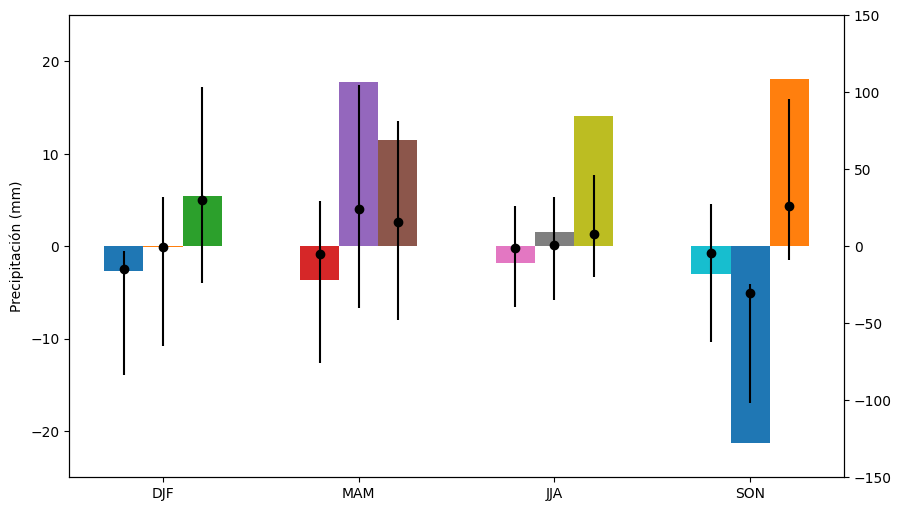

[[np.float32(71.01306)], [np.float32(34.4021)]]


In [117]:
#plot barplot for any season. x labels are the seasons grouped by experiment
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharex=True)

seasons_positions = [1, 2, 3, 4]
seasons_labels = ['DJF', 'MAM', 'JJA', 'SON']
width = 0.2

#DJF
ax.bar(seasons_positions[0]-width, np.mean(prep_hist_estacion['DJF'])-np.mean(prep_piControl_estacion['DJF']), width,  label='Historical')
ax.bar(seasons_positions[0], np.mean(prep_midHolocene_estacion['DJF'])-np.mean(prep_piControl_estacion['DJF']), width, label='MidHolocene')
ax.bar(seasons_positions[0]+width, np.mean(prep_lgm_estacion['DJF'])-np.mean(prep_piControl_estacion['DJF']), width, label='LGM')

#MAM
ax.bar(seasons_positions[1]-width, np.mean(prep_hist_estacion['MAM'])-np.mean(prep_piControl_estacion['MAM']), width, label='Historical')
ax.bar(seasons_positions[1], np.mean(prep_midHolocene_estacion['MAM'])-np.mean(prep_piControl_estacion['MAM']), width, label='MidHolocene')
ax.bar(seasons_positions[1]+width, np.mean(prep_lgm_estacion['MAM'])-np.mean(prep_piControl_estacion['MAM']), width, label='LGM')

#JJA
ax.bar(seasons_positions[2]-width, np.mean(prep_hist_estacion['JJA'])-np.mean(prep_piControl_estacion['JJA']), width, label='Historical')
ax.bar(seasons_positions[2], np.mean(prep_midHolocene_estacion['JJA'])-np.mean(prep_piControl_estacion['JJA']), width, label='MidHolocene')
ax.bar(seasons_positions[2]+width, np.mean(prep_lgm_estacion['JJA'])-np.mean(prep_piControl_estacion['JJA']), width, label='LGM')

#SON
ax.bar(seasons_positions[3]-width, np.mean(prep_hist_estacion['SON'])-np.mean(prep_piControl_estacion['SON']), width, label='Historical')
ax.bar(seasons_positions[3], np.mean(prep_midHolocene_estacion['SON'])-np.mean(prep_piControl_estacion['SON']), width, label='MidHolocene')
ax.bar(seasons_positions[3]+width, np.mean(prep_lgm_estacion['SON'])-np.mean(prep_piControl_estacion['SON']), width, label='LGM')

ax.set_ylabel('Precipitación (mm)')
ax.set_xticks(seasons_positions)
ax.set_xticklabels(seasons_labels)

ax.set_ylim(-25, 25)
#plot error bars but use extra right y-axis
ax2 = ax.twinx()

#delta
delta_hist_estacion_djf = ((prep_hist_estacion['DJF'] - np.mean(prep_piControl_estacion['DJF']))/np.mean(prep_piControl_estacion['DJF']))*100
delta_midHolocene_estacion_djf = ((prep_midHolocene_estacion['DJF'] - np.mean(prep_piControl_estacion['DJF']))/np.mean(prep_piControl_estacion['DJF']))*100
delta_lgm_estacion_djf = ((prep_lgm_estacion['DJF'] - np.mean(prep_piControl_estacion['DJF']))/np.mean(prep_piControl_estacion['DJF']))*100
delta_hist_estacion_mam = ((prep_hist_estacion['MAM'] - np.mean(prep_piControl_estacion['MAM']))/np.mean(prep_piControl_estacion['MAM']))*100
delta_midHolocene_estacion_mam = ((prep_midHolocene_estacion['MAM'] - np.mean(prep_piControl_estacion['MAM']))/np.mean(prep_piControl_estacion['MAM']))*100
delta_lgm_estacion_mam = ((prep_lgm_estacion['MAM'] - np.mean(prep_piControl_estacion['MAM']))/np.mean(prep_piControl_estacion['MAM']))*100
delta_hist_estacion_jja = ((prep_hist_estacion['JJA'] - np.mean(prep_piControl_estacion['JJA']))/np.mean(prep_piControl_estacion['JJA']))*100
delta_midHolocene_estacion_jja = ((prep_midHolocene_estacion['JJA'] - np.mean(prep_piControl_estacion['JJA']))/np.mean(prep_piControl_estacion['JJA']))*100
delta_lgm_estacion_jja = ((prep_lgm_estacion['JJA'] - np.mean(prep_piControl_estacion['JJA']))/np.mean(prep_piControl_estacion['JJA']))*100
delta_hist_estacion_son = ((prep_hist_estacion['SON'] - np.mean(prep_piControl_estacion['SON']))/np.mean(prep_piControl_estacion['SON']))*100
delta_midHolocene_estacion_son = ((prep_midHolocene_estacion['SON'] - np.mean(prep_piControl_estacion['SON']))/np.mean(prep_piControl_estacion['SON']))*100
delta_lgm_estacion_son = ((prep_lgm_estacion['SON'] - np.mean(prep_piControl_estacion['SON']))/np.mean(prep_piControl_estacion['SON']))*100

#delta mean
#asimetria bar error
#DJF
ax2.errorbar(seasons_positions[0]-width, np.mean(delta_hist_estacion_djf), yerr=[[np.abs(np.percentile(delta_hist_estacion_djf, 25))], [np.abs(np.percentile(delta_hist_estacion_djf, 75))]], fmt='o', color='black')
ax2.errorbar(seasons_positions[0], np.mean(delta_midHolocene_estacion_djf), yerr=[[np.abs(np.percentile(delta_midHolocene_estacion_djf, 25))], [np.abs(np.percentile(delta_midHolocene_estacion_djf, 75))]], fmt='o', color='black')
ax2.errorbar(seasons_positions[0]+width, np.mean(delta_lgm_estacion_djf), yerr=[[np.abs(np.percentile(delta_lgm_estacion_djf, 25))], [np.abs(np.percentile(delta_lgm_estacion_djf, 75))]], fmt='o', color='black')

#MAM
ax2.errorbar(seasons_positions[1]-width, np.mean(delta_hist_estacion_mam), yerr=[[np.abs(np.percentile(delta_hist_estacion_mam, 25))], [np.abs(np.percentile(delta_hist_estacion_mam, 75))]], fmt='o', color='black')
ax2.errorbar(seasons_positions[1], np.mean(delta_midHolocene_estacion_mam), yerr=[[np.abs(np.percentile(delta_midHolocene_estacion_mam, 25))], [np.abs(np.percentile(delta_midHolocene_estacion_mam, 75))]], fmt='o', color='black')
ax2.errorbar(seasons_positions[1]+width, np.mean(delta_lgm_estacion_mam), yerr=[[np.abs(np.percentile(delta_lgm_estacion_mam, 25))], [np.abs(np.percentile(delta_lgm_estacion_mam, 75))]], fmt='o', color='black')

#JJA
ax2.errorbar(seasons_positions[2]-width, np.mean(delta_hist_estacion_jja), yerr=[[np.abs(np.percentile(delta_hist_estacion_jja, 25))], [np.abs(np.percentile(delta_hist_estacion_jja, 75))]], fmt='o', color='black')
ax2.errorbar(seasons_positions[2], np.mean(delta_midHolocene_estacion_jja), yerr=[[np.abs(np.percentile(delta_midHolocene_estacion_jja, 25))], [np.abs(np.percentile(delta_midHolocene_estacion_jja, 75))]], fmt='o', color='black')
ax2.errorbar(seasons_positions[2]+width, np.mean(delta_lgm_estacion_jja), yerr=[[np.abs(np.percentile(delta_lgm_estacion_jja, 25))], [np.abs(np.percentile(delta_lgm_estacion_jja, 75))]], fmt='o', color='black')

#SON
ax2.errorbar(seasons_positions[3]-width, np.mean(delta_hist_estacion_son), yerr=[[np.abs(np.percentile(delta_hist_estacion_son, 25))], [np.abs(np.percentile(delta_hist_estacion_son, 75))]], fmt='o', color='black')
ax2.errorbar(seasons_positions[3], np.mean(delta_midHolocene_estacion_son), yerr=[[np.abs(np.percentile(delta_midHolocene_estacion_son, 25))], [np.abs(np.percentile(delta_midHolocene_estacion_son, 75))]], fmt='o', color='black')
ax2.errorbar(seasons_positions[3]+width, np.mean(delta_lgm_estacion_son), yerr=[[np.abs(np.percentile(delta_lgm_estacion_son, 25))], [np.abs(np.percentile(delta_lgm_estacion_son, 75))]], fmt='o', color='black')

ax2.set_ylim(-150, 150)

plt.show()

print([[np.abs(np.percentile(delta_hist_estacion_mam, 25))], [np.abs(np.percentile(delta_hist_estacion_mam, 75))]])


## Series de tiempo

In [14]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
df_lgm = pd.read_csv('W:/Proyectos/paleoclimate_global_simulations_chile_central/sub_projects/FONDECYT_11220930/results/conditions_mean/central_chile_precipitation_lgm.csv')
df_piControl = pd.read_csv('W:/Proyectos/paleoclimate_global_simulations_chile_central/sub_projects/FONDECYT_11220930/results/conditions_mean/central_chile_precipitation_piControl.csv')
df_midHolocene = pd.read_csv('W:/Proyectos/paleoclimate_global_simulations_chile_central/sub_projects/FONDECYT_11220930/results/conditions_mean/central_chile_precipitation_midHolocene.csv')
df_historical = pd.read_csv('W:/Proyectos/paleoclimate_global_simulations_chile_central/sub_projects/FONDECYT_11220930/results/conditions_mean/central_chile_precipitation_historical.csv')

In [12]:
total_anual_series_lgm = np.array([np.sum(x) for x in np.split(df_lgm['precipitation'].values, len(df_lgm['precipitation'].values)/12) ])
total_anual_series_piControl = np.array([np.sum(x) for x in np.split(df_piControl['precipitation'].values, len(df_piControl['precipitation'].values)/12) ])
total_anual_series_midHolocene = np.array([np.sum(x) for x in np.split(df_midHolocene['precipitation'].values, len(df_midHolocene['precipitation'].values)/12) ])
total_anual_series_historical = np.array([np.sum(x) for x in np.split(df_historical['precipitation'].values, len(df_historical['precipitation'].values)/12) ])


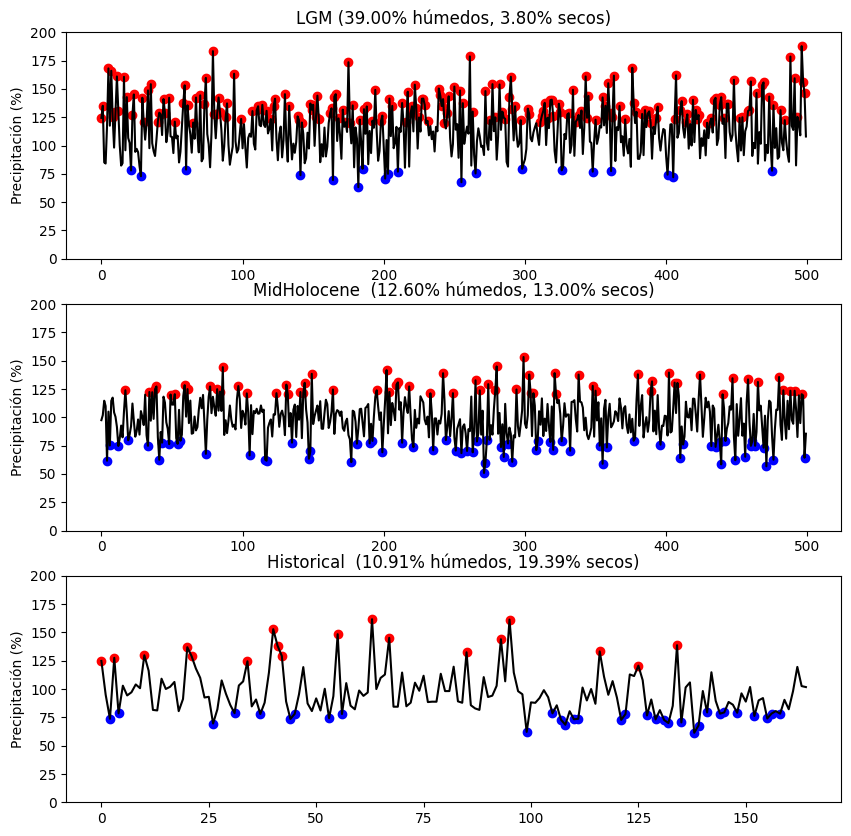

In [18]:
#plot 3 subplot series
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].plot((total_anual_series_lgm/np.mean(total_anual_series_piControl))*100, label='LGM', color='black')
for pp in (total_anual_series_lgm/np.mean(total_anual_series_piControl))*100:
    
    if pp >= 120:
        axs[0].scatter(np.where((total_anual_series_lgm/np.mean(total_anual_series_piControl))*100 == pp)[0], pp, color='red')
    elif pp <= 80:
        axs[0].scatter(np.where((total_anual_series_lgm/np.mean(total_anual_series_piControl))*100 == pp)[0], pp, color='blue')
n_wet = len(np.where((total_anual_series_lgm/np.mean(total_anual_series_piControl))*100 >= 120)[0])
n_dry = len(np.where((total_anual_series_lgm/np.mean(total_anual_series_piControl))*100 <= 80)[0])
n_total = len(total_anual_series_lgm)
axs[0].set_title('LGM' + f' ({n_wet/n_total*100:.2f}% húmedos, {n_dry/n_total*100:.2f}% secos)')
axs[0].set_ylabel('Precipitación (%)' )
axs[0].set_ylim(0, 200)

axs[1].plot((total_anual_series_midHolocene/np.mean(total_anual_series_piControl))*100, label='MidHolocene', color='black')
for pp in (total_anual_series_midHolocene/np.mean(total_anual_series_piControl))*100:
    if pp >= 120:
        axs[1].scatter(np.where((total_anual_series_midHolocene/np.mean(total_anual_series_piControl))*100 == pp)[0], pp, color='red')
    elif pp <= 80:
        axs[1].scatter(np.where((total_anual_series_midHolocene/np.mean(total_anual_series_piControl))*100 == pp)[0], pp, color='blue')
n_wet = len(np.where((total_anual_series_midHolocene/np.mean(total_anual_series_piControl))*100 >= 120)[0])
n_dry = len(np.where((total_anual_series_midHolocene/np.mean(total_anual_series_piControl))*100 <= 80)[0])
n_total = len(total_anual_series_midHolocene)
axs[1].set_title('MidHolocene ' + f' ({n_wet/n_total*100:.2f}% húmedos, {n_dry/n_total*100:.2f}% secos)')
axs[1].set_ylabel('Precipitación (%)')
axs[1].set_ylim(0, 200)

axs[2].plot((total_anual_series_historical/np.mean(total_anual_series_piControl))*100, label='Historical', color='black')
for pp in (total_anual_series_historical/np.mean(total_anual_series_piControl))*100:
    if pp >= 120:
        axs[2].scatter(np.where((total_anual_series_historical/np.mean(total_anual_series_piControl))*100 == pp)[0], pp, color='red')
    elif pp <= 80:
        axs[2].scatter(np.where((total_anual_series_historical/np.mean(total_anual_series_piControl))*100 == pp)[0], pp, color='blue')
n_wet = len(np.where((total_anual_series_historical/np.mean(total_anual_series_piControl))*100 >= 120)[0])
n_dry = len(np.where((total_anual_series_historical/np.mean(total_anual_series_piControl))*100 <= 80)[0])
n_total = len(total_anual_series_historical)
axs[2].set_title('Historical ' + f' ({n_wet/n_total*100:.2f}% húmedos, {n_dry/n_total*100:.2f}% secos)')
axs[2].set_ylabel('Precipitación (%)')
axs[2].set_ylim(0, 200)

plt.show()


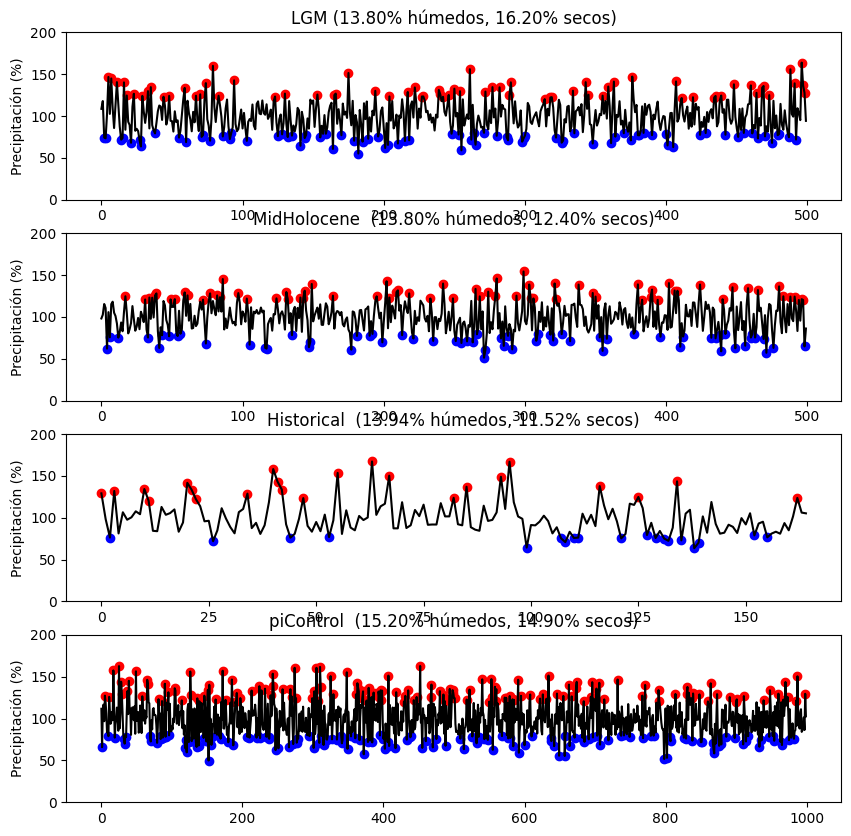

In [19]:
#plot 3 subplot series
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

axs[0].plot((total_anual_series_lgm/np.mean(total_anual_series_lgm))*100, label='LGM', color='black')
for pp in (total_anual_series_lgm/np.mean(total_anual_series_lgm))*100:
    
    if pp >= 120:
        axs[0].scatter(np.where((total_anual_series_lgm/np.mean(total_anual_series_lgm))*100 == pp)[0], pp, color='red')
    elif pp <= 80:
        axs[0].scatter(np.where((total_anual_series_lgm/np.mean(total_anual_series_lgm))*100 == pp)[0], pp, color='blue')
n_wet = len(np.where((total_anual_series_lgm/np.mean(total_anual_series_lgm))*100 >= 120)[0])
n_dry = len(np.where((total_anual_series_lgm/np.mean(total_anual_series_lgm))*100 <= 80)[0])
n_total = len(total_anual_series_lgm)
axs[0].set_title('LGM' + f' ({n_wet/n_total*100:.2f}% húmedos, {n_dry/n_total*100:.2f}% secos)')
axs[0].set_ylabel('Precipitación (%)' )
axs[0].set_ylim(0, 200)

axs[1].plot((total_anual_series_midHolocene/np.mean(total_anual_series_midHolocene))*100, label='MidHolocene', color='black')
for pp in (total_anual_series_midHolocene/np.mean(total_anual_series_midHolocene))*100:
    if pp >= 120:
        axs[1].scatter(np.where((total_anual_series_midHolocene/np.mean(total_anual_series_midHolocene))*100 == pp)[0], pp, color='red')
    elif pp <= 80:
        axs[1].scatter(np.where((total_anual_series_midHolocene/np.mean(total_anual_series_midHolocene))*100 == pp)[0], pp, color='blue')
n_wet = len(np.where((total_anual_series_midHolocene/np.mean(total_anual_series_midHolocene))*100 >= 120)[0])
n_dry = len(np.where((total_anual_series_midHolocene/np.mean(total_anual_series_midHolocene))*100 <= 80)[0])
n_total = len(total_anual_series_midHolocene)
axs[1].set_title('MidHolocene ' + f' ({n_wet/n_total*100:.2f}% húmedos, {n_dry/n_total*100:.2f}% secos)')
axs[1].set_ylabel('Precipitación (%)')
axs[1].set_ylim(0, 200)

axs[2].plot((total_anual_series_historical/np.mean(total_anual_series_historical))*100, label='Historical', color='black')
for pp in (total_anual_series_historical/np.mean(total_anual_series_historical))*100:
    if pp >= 120:
        axs[2].scatter(np.where((total_anual_series_historical/np.mean(total_anual_series_historical))*100 == pp)[0], pp, color='red')
    elif pp <= 80:
        axs[2].scatter(np.where((total_anual_series_historical/np.mean(total_anual_series_historical))*100 == pp)[0], pp, color='blue')
n_wet = len(np.where((total_anual_series_historical/np.mean(total_anual_series_historical))*100 >= 120)[0])
n_dry = len(np.where((total_anual_series_historical/np.mean(total_anual_series_historical))*100 <= 80)[0])
n_total = len(total_anual_series_historical)
axs[2].set_title('Historical ' + f' ({n_wet/n_total*100:.2f}% húmedos, {n_dry/n_total*100:.2f}% secos)')
axs[2].set_ylabel('Precipitación (%)')
axs[2].set_ylim(0, 200)

axs[3].plot((total_anual_series_piControl/np.mean(total_anual_series_piControl))*100, label='piControl', color='black')
for pp in (total_anual_series_piControl/np.mean(total_anual_series_piControl))*100:
    if pp >= 120:
        axs[3].scatter(np.where((total_anual_series_piControl/np.mean(total_anual_series_piControl))*100 == pp)[0], pp, color='red')
    elif pp <= 80:
        axs[3].scatter(np.where((total_anual_series_piControl/np.mean(total_anual_series_piControl))*100 == pp)[0], pp, color='blue')
n_wet = len(np.where((total_anual_series_piControl/np.mean(total_anual_series_piControl))*100 >= 120)[0])
n_dry = len(np.where((total_anual_series_piControl/np.mean(total_anual_series_piControl))*100 <= 80)[0])
n_total = len(total_anual_series_piControl)
axs[3].set_title('piControl ' + f' ({n_wet/n_total*100:.2f}% húmedos, {n_dry/n_total*100:.2f}% secos)')
axs[3].set_ylabel('Precipitación (%)')
axs[3].set_ylim(0, 200)

plt.show()